(1) Exploratory Data Analysis (EDA)

- Show summary statistics (especially the target variable).
- Identify and discuss any data issues (e.g., missing values, incorrect ranges).

In [1]:
#import necessray libralies
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
#read the csv file
df=pd.read_csv("airbnb.csv")

In [3]:
#-----------------------------------
#show the summary statistics
#-----------------------------------
#The target variable is price

print(df.describe())
print(df.price)

                 id       host_id      latitude     longitude         price  \
count  27106.000000  2.710600e+04  27106.000000  27106.000000  26595.000000   
mean   13692.979156  6.817564e+07     40.728885    -73.952079    164.604200   
std     7905.881696  7.911806e+07      0.054639      0.046297   6772.488296   
min        1.000000  2.438000e+03     40.506410    -74.242850 -44039.906822   
25%     6851.250000  7.958923e+06     40.690022    -73.983117     66.000000   
50%    13688.500000  3.104429e+07     40.723105    -73.955720    107.000000   
75%    20541.750000  1.074344e+08     40.763098    -73.935830    180.000000   
max    27379.000000  2.743213e+08     40.913060    -73.717950  44388.408761   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    26586.000000       26583.000000       21340.000000   
mean         7.079687          21.255378           1.379605   
std        614.394492        1369.984414          58.940016   
min      -3995.969493       -8836.73

In [4]:
#-----------------------------------
#identify and manage the data issue
#-----------------------------------
#filter out the unrealistic data
df=df[df["price"]>0]
df=df[df["minimum_nights"]>0]
df=df[df["number_of_reviews"]>0]
df=df[df["reviews_per_month"]>0]
df=df[df["calculated_host_listings_count"]>0]
df=df[df["availability_365"]>=0]
df=df[df["availability_365"]<=365]


#manage the column last_review because the datetime data is stilled be treated as string, so the meaning is not very useful
df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")
df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")
df["days_since_last_review"] = (datetime.now()-df["last_review"]).dt.days

df=df.drop(columns=["id", "name", "host_id", "neighbourhood", "last_review"])

#counting negative value integers
negative_df=df.select_dtypes(include=[np.number])<0
negative_df=negative_df.drop("longitude",axis=1)
print(negative_df)
print(negative_df.sum())

#counting NaN
print(df.isna().sum())

#replace the negative value into NaN value
for cols in negative_df.columns:
    df.loc[negative_df[cols]==True, cols] = np.nan

#all the NaN value will be fixed in the next process




       latitude  price  minimum_nights  number_of_reviews  reviews_per_month  \
0         False  False           False              False              False   
1         False  False           False              False              False   
4         False  False           False              False              False   
5         False  False           False              False              False   
9         False  False           False              False              False   
...         ...    ...             ...                ...                ...   
27098     False  False           False              False              False   
27100     False  False           False              False              False   
27103     False  False           False              False              False   
27104     False  False           False              False              False   
27105     False  False           False              False              False   

       calculated_host_listings_count  

<Axes: xlabel='price', ylabel='Count'>

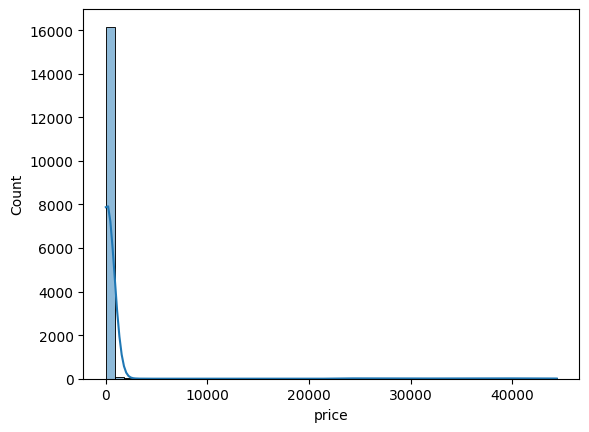

In [5]:
#-----------------------------------
#plot the data in graph to see how the range
#-----------------------------------
sns.histplot(df["price"], bins=50, kde=True)


<Axes: xlabel='price', ylabel='Count'>

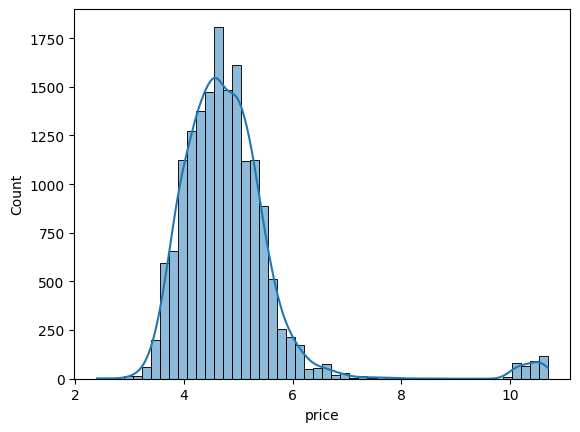

In [6]:
sns.histplot(np.log1p(df["price"]), bins=50, kde=True)

<Axes: xlabel='price', ylabel='Count'>

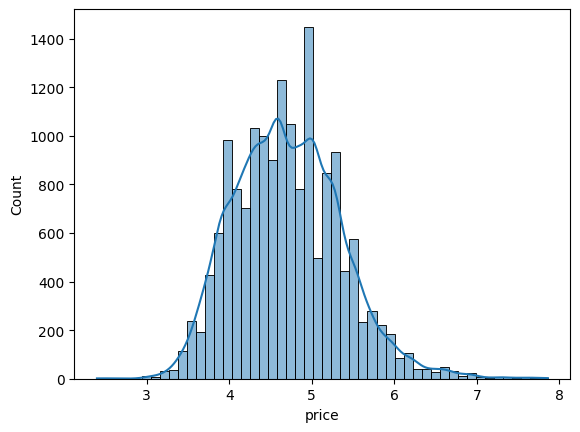

In [7]:
#in the result, the data looks more like normal distribution with some outliers 
#(which is better for training than non-normal data)

#-----------------------------------
#manage the outlier
#-----------------------------------
#clip out the outlier in price
df=df[np.log1p(df["price"])<8]
sns.histplot(np.log1p(df["price"]), bins=50, kde=True)

In [8]:
#continue to manage the outlier in other columns that are numeric

print(df.shape)
for col in df.select_dtypes(include=[np.number]).columns:
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    upperbound=1.5*IQR+Q3
    lowerbound=Q1-1.5*IQR
    df=df[(df[col]>=lowerbound)&(df[col]<=upperbound)]
print(df.shape)



(16238, 12)
(8250, 12)


In [9]:
#-----------------------------------
#discuss the data issue
#-----------------------------------

#for numeric data
#data in numeric columns: price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365
#most data should not be a negative value because it is received by counting so negative value is unrealistic
#data within an appropriate range are better for model training than scattered data, so filter out the outliers by using IQR

#for nominal data
#the NaN value data should be next replaced with "most frequent" data to be usable

(2) Data Preprocessing

- Perform proper preprocessing using scikit-learn (e.g., encoding, scaling, splitting).
- Perform a proper train–test split (70% training, 30% testing) using your first 8 digits student ID (without 21) as the random seed. 

In [10]:
#-----------------------------------
#data preprocessing: proper preprocessing & perform train_test_split
#-----------------------------------
#data cleaning
X=df.drop(columns=["price"])
y=df["price"]

#perform a train_test_split to seperate between data for training and data for testing
X_train,X_test,y_train,y_test=train_test_split(
    X,y,
    test_size=0.3,
    random_state=67380891
)
#seperate dataframe into nominal data and numeric data
numeric_cols= X_train.select_dtypes(include=[np.number]).columns
nominal_cols= X_train.select_dtypes(exclude=[np.number]).columns

#for numeric values, fix the data issue by replacing NaN value with mean using SimpleImputer
numeric_pipe=Pipeline(steps=[
    ("numeric_imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

#for nominal values, fix the data issue by replacing NaN value with mode using SimpleImputer
nominal_pipe=Pipeline(steps=[
    ("nominal_imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

#use transformer to apply the pipeline
preprocessor=ColumnTransformer(transformers=[
    ("num", numeric_pipe, numeric_cols),
    ("nom", nominal_pipe, nominal_cols),
])



(3) Model Building

- Train at least two models with proper parameter configuration:
    - one tree-based model, and
    - one regression-based model.

- Explain the model outputs (e.g., tree visualization, regression coefficients).

In [11]:
#-----------------------------------
#model building
#-----------------------------------

#tree based model: DecisionTreeRegressor
tree_pipe= Pipeline([
    ("preprecessor", preprocessor),
    ("model",DecisionTreeRegressor(max_depth= 5,min_samples_leaf=40, random_state=67380891))
])

#regression based model: LinearRegression
regression_pipe= Pipeline([
    ("preprecessor", preprocessor),
    ("model",LinearRegression())
])

y_train_log=np.log1p(y_train)
tree_pipe.fit(X_train,y_train_log)
y_pred_tree_log=tree_pipe.predict(X_test)
y_pred_tree=np.expm1(y_pred_tree_log)

regression_pipe.fit(X_train,y_train_log)
y_pred_regression_log=regression_pipe.predict(X_test)
y_pred_regression=np.expm1(y_pred_regression_log)

In [12]:
#use GridSearch to find best parameters for tree_model

param_grid_tree = {
    "model__max_depth": [10,20,30],
    "model__min_samples_leaf": [1, 2, 5, 10,20,40],
    "model__min_samples_split": [2, 5, 10],
    "model__random_state":[67380891]
}

gs_tree= GridSearchCV(
    estimator=tree_pipe, 
    param_grid=param_grid_tree, 
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

#refit the model
gs_tree.fit(X_train,y_train_log)
print(f"Best params: \n{str(gs_tree.best_params_)}")

best_tree_model= gs_tree.best_estimator_
y_pred_tree_log=best_tree_model.predict(X_test)
y_pred_tree=np.expm1(y_pred_tree_log)

Best params: 
{'model__max_depth': 20, 'model__min_samples_leaf': 40, 'model__min_samples_split': 2, 'model__random_state': 67380891}


(4) Evaluation

- Compare both models using mean squared error (mse) and R2.
- Discuss which model performs better and why, based on the evaluation metrics.

In [16]:
#-----------------------------------
#model evaluation
#-----------------------------------

#MSE and r2 for tree_model
MSE_tree=mean_squared_error(y_test, y_pred_tree)
r2_tree=r2_score(y_test, y_pred_tree)

#MSE and r2 for regressor_model
MSE_regressor=mean_squared_error(y_test, y_pred_regression)
r2_regressor=r2_score(y_test, y_pred_regression)

print("DecisionTreeRegressor model")
print(f"MSE: {MSE_tree:.3f}")
print(f"r2 score: {r2_tree:.3f}")

print("\nLinearRegressor model")
print(f"MSE: {MSE_regressor:.3f}")
print(f"r2 score: {r2_regressor:.3f}")

DecisionTreeRegressor model
MSE: 2261.092
r2 score: 0.488

LinearRegressor model
MSE: 2837.459
r2 score: 0.357


In [ ]:
"""
model discussion:

MSE (Mean Squared Error) measures how far, on average, predictions deviate from actual prices.
so, lower MSE is better. (closer to the actual price)

r2 (Coefficient of Determination) measures how much variance in price the model explains.
so, higher r2 is better. (more similar to the actual price)

from this,
DecisionTreeRegressor model
MSE: 2261.092
r2 score: 0.488

LinearRegressor model
MSE: 2837.459
r2 score: 0.357

It can be concluded that The DecisionTreeRegressor performs better (r2: 0.488>0.357) 
because Airbnb prices depend on nonlinear and categorical factors, which linear regression cannot keep up 
effectively. Still, both models show room for improvement — consider ensemble methods and refined 
preprocessing to push r2 beyond 0.6.

"""

'\nmodel discussion:\n\nMSE (Mean Squared Error) measures how far, on average, predictions deviate from actual prices.\nso, lower MSE is better. (closer to the actual price)\n\nr2 (Coefficient of Determination) measures how much variance in price the model explains.\nso, higher r2 is better. (more similar to the actual price)\n\nfrom this,\nDecisionTreeRegressor model\nMSE: 2261.092\nr2 score: 0.488\n\nLinearRegressor model\nMSE: 2261.092\nr2 score: 0.357\n\nIt can be concluded that The DecisionTreeRegressor performs better (r2: 0.488>0.357) \nbecause Airbnb prices depend on nonlinear and categorical factors, which linear regression connot keep up \neffectively. Still, both models show room for improvement — consider ensemble methods and refined \npreprocessing to push r2 beyond 0.6.\n\n'